# **AAPL Sentiment Analysis Project**

## Overview

This project develops a robust sentiment analysis system to track real-time public and media sentiment for Apple Inc. (NASDAQ: AAPL) using data from 3 sources:

1. X (formerly Twitter)
2. Google Trends
3. NewsAPI

By leveraging natural language processing (NLP) with VADER, time-series analysis, and visualization techniques, the system generates actionable insights for quantitative trading strategies. The analysis focuses on identifying sentiment-driven signals that correlate with price movements, volatility, and event-driven catalysts, such as Apple’s WWDC event which took place the week of June 9. WWDC 2025 introduced iOS 26 with a ”Liquid Glass” design, live translation, an overhauled Phone app, iPadOS 26 with a new windowing system, and macOS 26 (Tahoe) with enhanced customization.

This work demonstrates proficiency in data collection, cleaning, statistical modeling, and visualization, tailored to support alpha generation and risk management.


In [1]:
import tweepy
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pytrends.request import TrendReq
from newsapi import NewsApiClient
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# X (Twitter) Sentiment Analysis on Apple

Real-time X posts were collected in real time to capture the current sentiment environment. These provide a pulse on retail investor and consumer sentiment, often serving as leading indicators for short-term market reactions.

## Data Collection

- **Source**: X (formerly Twitter) API v2
- **Query**: Tweets discussing Apple's ticker, operating systems, or recent developer event in June 2025
- **Filters**: English language, excluding retweets, replies and spam-related tweets
- **Fields Collected**: `text`, `created_at`, `retweet_count`, `like_count`, `username` (where available)

In [2]:
# X API setup

from config import BEARER_TOKEN, NEWS_API_KEY

def collect_x_posts(query='("AAPL" OR iOS OR iPadOS OR macOS OR WWDC) -"RT" -"dm me" -"send me" -Paypal -Venmo', max_results=100):
    url = "https://api.x.com/2/tweets/search/recent"
    headers = {
        "Authorization": f"Bearer {BEARER_TOKEN}"
    }
    params = {
        "query": query + " lang:en -is:retweet -is:reply",
        "max_results": max_results,
        "tweet.fields": "created_at,author_id,public_metrics",
        "user.fields": "username"
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    data = response.json()
    posts = []
    for tweet in data.get('data', []):
        posts.append({
            'text': tweet['text'],
            'created_at': tweet['created_at'],
            'username': tweet.get('username', 'unknown'),
            'retweet_count': tweet['public_metrics']['retweet_count'],
            'like_count': tweet['public_metrics']['like_count']
        })
    
    return pd.DataFrame(posts)

In [3]:
x_posts = collect_x_posts()

In [4]:
x_posts.head()

,text,created_at,username,retweet_count,like_count
0,#Scrivener 3 on Windows &amp; macOS Tip of the...,2025-06-18T05:15:30.000Z,unknown,0,0
1,Cast Videos from PC to TV on Windows 10 (PC/Ta...,2025-06-18T05:13:45.000Z,unknown,0,0
2,*#GOLD BUY 𝐓𝐏 3 𝐇𝐈𝐓 230+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:28.000Z,unknown,0,0
3,Have yall seen the iOS 26? It’s so cuteeeee,2025-06-18T05:13:08.000Z,unknown,0,0
4,*#GOLD BUY 𝐓𝐏 2 𝐇𝐈𝐓 190+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:02.000Z,unknown,0,0


## Data Cleaning

- Remove URLs, mentions, hashtags, non-letter characters and extra whitespace
- Created a new column `cleaned_text` for sentiment analysis

In [5]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

In [6]:
# Clean text

x_posts['cleaned_text'] = x_posts['text'].apply(clean_text)

x_posts.head()

,text,created_at,username,retweet_count,like_count,cleaned_text
0,#Scrivener 3 on Windows &amp; macOS Tip of the...,2025-06-18T05:15:30.000Z,unknown,0,0,Scrivener on Windows amp macOS Tip of the Day ...
1,Cast Videos from PC to TV on Windows 10 (PC/Ta...,2025-06-18T05:13:45.000Z,unknown,0,0,Cast Videos from PC to TV on Windows PCTablet ...
2,*#GOLD BUY 𝐓𝐏 3 𝐇𝐈𝐓 230+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:28.000Z,unknown,0,0,GOLD BUY pips Xauusd Xau Gold Gbpusd Eurusd SP...
3,Have yall seen the iOS 26? It’s so cuteeeee,2025-06-18T05:13:08.000Z,unknown,0,0,Have yall seen the iOS Its so cuteeeee
4,*#GOLD BUY 𝐓𝐏 2 𝐇𝐈𝐓 190+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:02.000Z,unknown,0,0,GOLD BUY pips Xauusd Xau Gold Gbpusd Eurusd SP...


## Analysis

- **Sentiment Tool**: VADER to compute a compound sentiment score ranging from -1 (very negative) to +1 (very positive)
- **Labeling Rules**:
    - `>= 0.05`: Positive
    - `<= -0.05`: Negative
    - Else: Neutral


- **Output**: Bar chart showing sentiment distribution (positive, neutral, negative)

In [7]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [8]:
# Get and classify sentiment score

x_posts['sentiment_score'] = x_posts['cleaned_text'].apply(get_sentiment_score)
x_posts['sentiment_label'] = x_posts['sentiment_score'].apply(label_sentiment)

In [9]:
x_posts.head()

,text,created_at,username,retweet_count,like_count,cleaned_text,sentiment_score,sentiment_label
0,#Scrivener 3 on Windows &amp; macOS Tip of the...,2025-06-18T05:15:30.000Z,unknown,0,0,Scrivener on Windows amp macOS Tip of the Day ...,0.0000,Neutral
1,Cast Videos from PC to TV on Windows 10 (PC/Ta...,2025-06-18T05:13:45.000Z,unknown,0,0,Cast Videos from PC to TV on Windows PCTablet ...,0.5719,Positive
2,*#GOLD BUY 𝐓𝐏 3 𝐇𝐈𝐓 230+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:28.000Z,unknown,0,0,GOLD BUY pips Xauusd Xau Gold Gbpusd Eurusd SP...,0.0000,Neutral
3,Have yall seen the iOS 26? It’s so cuteeeee,2025-06-18T05:13:08.000Z,unknown,0,0,Have yall seen the iOS Its so cuteeeee,0.0000,Neutral
4,*#GOLD BUY 𝐓𝐏 2 𝐇𝐈𝐓 190+ pips 𝐒𝐔𝐂𝐂𝐄𝐒𝐒𝐅𝐔𝐋𝐋...,2025-06-18T05:13:02.000Z,unknown,0,0,GOLD BUY pips Xauusd Xau Gold Gbpusd Eurusd SP...,0.0000,Neutral


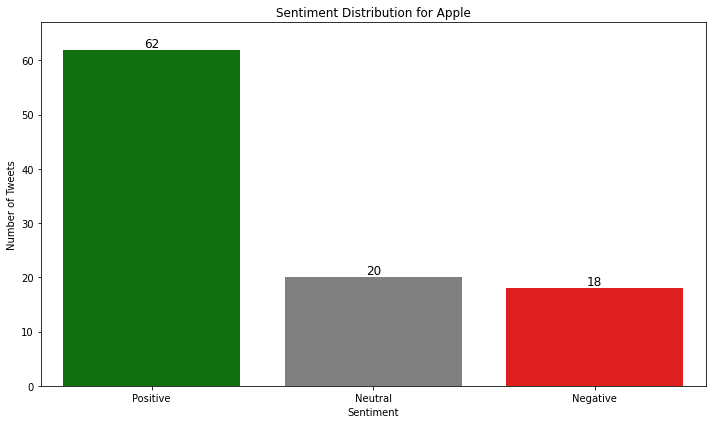

Average sentiment score: 0.268


In [10]:
# Count plot of sentiment categories

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=x_posts, 
    x='sentiment_label', 
    order=['Positive', 'Neutral', 'Negative'],
    palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
)

plt.title("Sentiment Distribution for Apple")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")

max_count = x_posts['sentiment_label'].value_counts().max()
plt.ylim(0, max_count + 5)

for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5, str(count), ha="center", fontsize=12)

plt.tight_layout()
plt.show()

print(f"Average sentiment score: {x_posts['sentiment_score'].mean():.3f}")

## Observations

- **Average sentiment score**: `0.268`, indicating moderate positive sentiment, reflecting enthusiasm or product satisfaction This aligns with seasonal optimism following the WWDC 2025 announcements.
    - Terms such as iOS, macOS, and WWDC likely captured product fans and tech influencers, contributing to the overall positivity.
- **Trading Insight** : Positive sentiment spikes post-WWDC suggest short-term bullish signals, potentially informing momentum or event-driven trades.
- **Limitation**: Despite query filtering and sentiment scoring, residual noise persists, such as irrelevant or off-topic mentions (e.g., tech tutorials or promotions unrelated to Apple Inc.). This highlights the importance of deeper content verification, perhaps via Named Entity Recognition (NER) or topic modeling.
- **Quant Application**: Sentiment scores can be integrated into a factor model, weighted by engagement metrics (retweet/like counts), to predict intraday volatility or price momentum.

# Google Search Trend Analysis on Apple

Google search interest reflects public curiosity and interest, often peaking near major events like product launches or earnings. It may also serve as a proxy for market attention and potential volatility catalysts.

## Data Collection

- **Source**: Google Trends via `pytrends`
- **Keyword**: “Apple”
- **Timeframe**: Past 3 months

## Data Cleaning
- Minimal cleaning required, the dataset is structured.
- Removed the `isPartial` column if present.
- Computed a 3-week centered rolling average to smooth fluctuations.

In [11]:
# Fetch Google search interest for Apple over the past 3 months

pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Apple"]

pytrends.build_payload(kw_list, timeframe='today 3-m')
interest_df = pytrends.interest_over_time()

if 'isPartial' in interest_df.columns:
    interest_df = interest_df.drop(columns='isPartial')

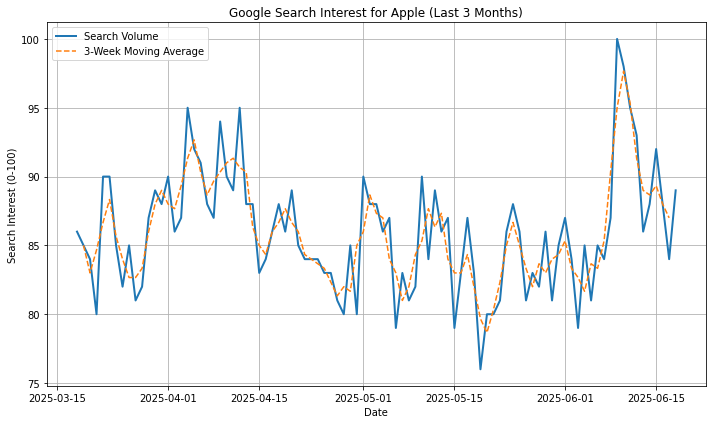

In [12]:
# Plot trendline and rolling average

plt.figure(figsize=(10, 6))
sns.lineplot(data=interest_df, x=interest_df.index, y="Apple", label="Search Volume", linewidth=2)

interest_df['rolling_avg'] = interest_df['Apple'].rolling(window=3, center=True).mean()
sns.lineplot(data=interest_df, x=interest_df.index, y="rolling_avg", label="3-Week Moving Average", linestyle='--')

plt.title("Google Search Interest for Apple (Last 3 Months)")
plt.xlabel("Date")
plt.ylabel("Search Interest (0-100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Observations

- **Spike Analysis**: A clear spike in search interest occurred in early June, aligning precisely with Apple’s annual developer conference, WWDC 2025. This reinforces the platform’s relevance as a proxy for public attention around event-driven catalysts.
- **Trading Insight**: The trend pattern is consistent with historical Apple cycles, where search volume clusters around product reveals or earnings, then fades. Search volume spikes can precede volatility, useful for timing options trades or hedging strategies.
- **Potential Enhancement**: If segmented by geography (e.g., U.S. vs global), this data could further highlight regional sensitivity to Apple announcements, which may tie to sales exposure or marketing push.

# News Sentiment Analysis on Apple

News headlines reflect the narrative environment that shape investor perception, institutional discourse, and analyst commentary.

## Data Collection
- **Source**: NewsAPI
- **Query**: “Apple”
- **Filters**: English language, sorted by relevancy, limited to 100 articles
- **Fields Collected**: `title`, `description`, `content`, `publishedAt`

In [13]:
# Fetch 100 Google news articles for Apple

newsapi = NewsApiClient(api_key=NEWS_API_KEY)

articles = newsapi.get_everything(q='Apple', language='en', sort_by='relevancy', page_size=100)

news_list = []
for a in articles['articles']:
    news_list.append({
        'title': a['title'],
        'description': a['description'],
        'content': a['content'],
        'publishedAt': a['publishedAt']
    })

news_df = pd.DataFrame(news_list)
news_df['text'] = news_df['title'] + " " + news_df['description'].fillna('')

In [14]:
news_df.head()

,title,description,content,publishedAt,text
0,Apple’s new Games app lets you challenge your ...,Apple is launching a new app that acts as a ce...,Another gaming initiative from Apple thats mea...,2025-06-09T18:09:03Z,Apple’s new Games app lets you challenge your ...
1,Apple’s DIY repair program now covers iPads,Apple is expanding its self-service repair pro...,"Recent iPad, mini, Air, and Pro models are now...",2025-05-28T11:48:45Z,Apple’s DIY repair program now covers iPads Ap...
2,Apple is ready to replace Game Center with a m...,Apple plans to announce an app focused on vide...,"The company has also acquired RAC7, the develo...",2025-05-27T20:17:31Z,Apple is ready to replace Game Center with a m...
3,Apple WWDC 2025: the 13 biggest announcements,Apple packed a bunch of major updates into its...,Apple packed a bunch of major updates into its...,2025-06-09T19:04:31Z,Apple WWDC 2025: the 13 biggest announcements ...
4,Apple is trying to get ‘LLM Siri’ back on track,Apple Intelligence has been a wreck since its ...,Bloombergs Mark Gurman details why Apple Intel...,2025-05-18T23:06:37Z,Apple is trying to get ‘LLM Siri’ back on trac...


## Data Cleaning
- Used the `clean_text()` function remove any unwanted texts and create a `cleaned_text` column

In [15]:
# Clean text

news_df['cleaned_text'] = news_df['text'].apply(clean_text)
news_df.head()

,title,description,content,publishedAt,text,cleaned_text
0,Apple’s new Games app lets you challenge your ...,Apple is launching a new app that acts as a ce...,Another gaming initiative from Apple thats mea...,2025-06-09T18:09:03Z,Apple’s new Games app lets you challenge your ...,Apples new Games app lets you challenge your f...
1,Apple’s DIY repair program now covers iPads,Apple is expanding its self-service repair pro...,"Recent iPad, mini, Air, and Pro models are now...",2025-05-28T11:48:45Z,Apple’s DIY repair program now covers iPads Ap...,Apples DIY repair program now covers iPads App...
2,Apple is ready to replace Game Center with a m...,Apple plans to announce an app focused on vide...,"The company has also acquired RAC7, the develo...",2025-05-27T20:17:31Z,Apple is ready to replace Game Center with a m...,Apple is ready to replace Game Center with a m...
3,Apple WWDC 2025: the 13 biggest announcements,Apple packed a bunch of major updates into its...,Apple packed a bunch of major updates into its...,2025-06-09T19:04:31Z,Apple WWDC 2025: the 13 biggest announcements ...,Apple WWDC the biggest announcements Apple pac...
4,Apple is trying to get ‘LLM Siri’ back on track,Apple Intelligence has been a wreck since its ...,Bloombergs Mark Gurman details why Apple Intel...,2025-05-18T23:06:37Z,Apple is trying to get ‘LLM Siri’ back on trac...,Apple is trying to get LLM Siri back on track ...


## Analysis

- Used the `get_sentiment_score()` and `label_sentiment()` functions to get and label sentiment scores
- **Output**: Bar chart showing sentiment distribution (positive, neutral, negative)

In [16]:
# Get and classify sentiment score

news_df['sentiment_score'] = news_df['cleaned_text'].apply(get_sentiment_score)
news_df['sentiment_label'] = news_df['sentiment_score'].apply(label_sentiment)
news_df.head()

,title,description,content,publishedAt,text,cleaned_text,sentiment_score,sentiment_label
0,Apple’s new Games app lets you challenge your ...,Apple is launching a new app that acts as a ce...,Another gaming initiative from Apple thats mea...,2025-06-09T18:09:03Z,Apple’s new Games app lets you challenge your ...,Apples new Games app lets you challenge your f...,0.7579,Positive
1,Apple’s DIY repair program now covers iPads,Apple is expanding its self-service repair pro...,"Recent iPad, mini, Air, and Pro models are now...",2025-05-28T11:48:45Z,Apple’s DIY repair program now covers iPads Ap...,Apples DIY repair program now covers iPads App...,0.0000,Neutral
2,Apple is ready to replace Game Center with a m...,Apple plans to announce an app focused on vide...,"The company has also acquired RAC7, the develo...",2025-05-27T20:17:31Z,Apple is ready to replace Game Center with a m...,Apple is ready to replace Game Center with a m...,0.6249,Positive
3,Apple WWDC 2025: the 13 biggest announcements,Apple packed a bunch of major updates into its...,Apple packed a bunch of major updates into its...,2025-06-09T19:04:31Z,Apple WWDC 2025: the 13 biggest announcements ...,Apple WWDC the biggest announcements Apple pac...,0.2732,Positive
4,Apple is trying to get ‘LLM Siri’ back on track,Apple Intelligence has been a wreck since its ...,Bloombergs Mark Gurman details why Apple Intel...,2025-05-18T23:06:37Z,Apple is trying to get ‘LLM Siri’ back on trac...,Apple is trying to get LLM Siri back on track ...,0.0516,Positive


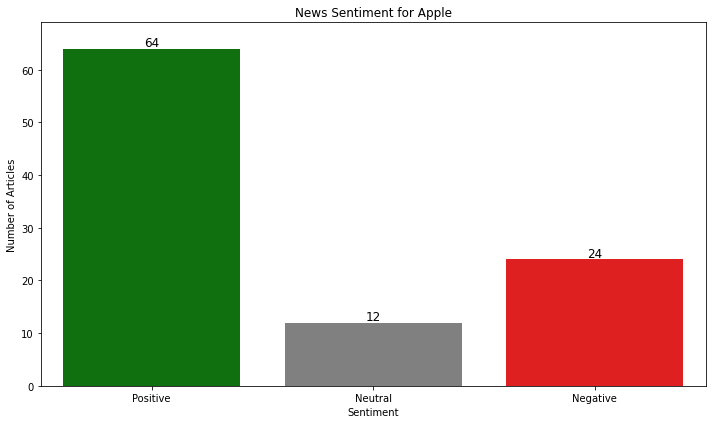

Average news sentiment score: 0.226


In [17]:
# Count plot of sentiment categories

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=news_df, 
    x='sentiment_label', 
    order=['Positive', 'Neutral', 'Negative'],
    palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
)

plt.title("News Sentiment for Apple")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")

max_count = news_df['sentiment_label'].value_counts().max()
plt.ylim(0, max_count + 5)

for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5, str(count), ha="center", fontsize=12)

plt.tight_layout()
plt.show()

print(f"Average news sentiment score: {news_df['sentiment_score'].mean():.3f}")

## Observations

- **Average sentiment score**: `0.226`, slightly lower than X posts, which is expected from more conservative institutional or journalistic language. The media often presents more balanced or skeptical perspectives, especially on emerging product lines.
- **Trading Insight**: Sentiment scores skewed positive but were clustered near neutral, reflecting informational tone over opinionated content. Neutral-heavy sentiment suggests stable long-term narratives, suitable for value investing or pairs trading with competitors.
- **Potential Enhancement**: Weighting articles by publisher credibility or using topic modeling could refine sentiment signals for portfolio allocation.

# Conclusion

This sentiment analysis system integrates X posts, Google Trends, and news data to quantify sentiment around AAPL’s WWDC 2025 new releases, including iOS 26’s ”Liquid Glass” design, iPadOS 26’s windowing system, and macOS 26 (Tahoe). 

The positive X sentiment (0.268) and news sentiment (0.226) suggest short-term bullish opportunities, while Google Trends spikes highlight volatility windows. For quant finance, this system can be extended to:

- **Factor Models**: Incorporate sentiment scores as alpha factors in multi-factor models.
- **Risk Management**: Use sentiment volatility to adjust position sizing or hedge ratios.
- **Event Trading**: Leverage event-driven sentiment spikes for options or momentum strategies.

Future improvements include NER for noise reduction, cointegration analysis for pairs trading, and Monte Carlo simulations to stress-test sentiment-driven trade signals, aligning with my expertise in Python-based analytics and econometric modeling.